In [1]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

In [2]:
from sklearn.model_selection import train_test_split

# 数据预处理
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Epoch 1/3
750/750 [==============================] - 3s 3ms/step - loss: 1.6503 - accuracy: 0.5479
Epoch 2/3
750/750 [==============================] - 3s 3ms/step - loss: 0.6801 - accuracy: 0.8260
Epoch 3/3
750/750 [==============================] - 3s 3ms/step - loss: 0.4308 - accuracy: 0.8787


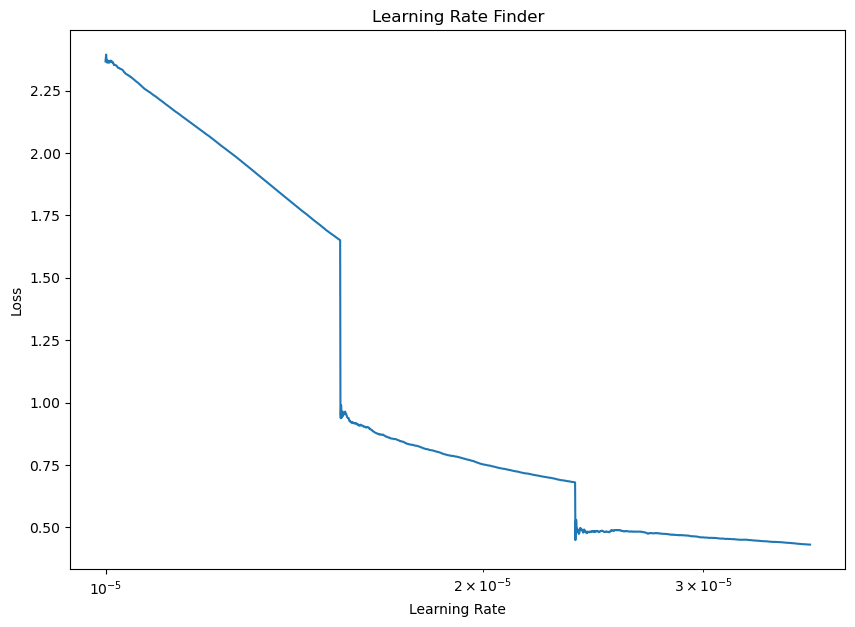

313/313 [==============================] - 1s 2ms/step - loss: 0.2984 - accuracy: 0.9177


[0.2984394431114197, 0.9176999926567078]

In [3]:
# 学习率搜索函数
import matplotlib.pyplot as plt
def lr_finder(model, train_data, epochs=1, start_lr=1e-5, end_lr=1e-1):
    # 自定义回调来逐步增加学习率
    class LRFinder(tf.keras.callbacks.Callback):
        def __init__(self, start_lr, end_lr):
            super().__init__()
            self.start_lr = start_lr
            self.end_lr = end_lr
            self.lr_mult = (end_lr / start_lr) ** (1 / (len(train_data[0]) // epochs)) 
            self.lrs = []
            self.losses = []
 
        def on_train_begin(self, logs=None):
            tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
 
        def on_batch_end(self, batch, logs=None):
            # 记录当前学习率和损失
            current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
            self.lrs.append(current_lr)
            self.losses.append(logs['loss'])
 
            # 更新学习率
            new_lr = self.lr_mult * current_lr
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
        
        def on_epoch_end(self, epoch, logs=None):
            print(f"Epoch {epoch+1}/{epochs} - Learning rate: {self.model.optimizer.learning_rate.numpy():.5f} - Loss: {logs['loss']:.5f}")
 
    # 运行学习率搜索
    lr_finder_callback = LRFinder(start_lr, end_lr)
    model.fit(
        train_data[0], train_data[1],
        batch_size=64,
        epochs=epochs,
        callbacks=[lr_finder_callback],
        verbose=1
    )
 
    # 绘制学习率与损失的关系
    plt.figure(figsize=(10, 7))
    plt.plot(lr_finder_callback.lrs, lr_finder_callback.losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')
    plt.show()
 
    return lr_finder_callback
 
# 构建基础模型
def build_base_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(28*28,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    return model
 
# 创建基础模型实例
base_model = build_base_model()
 
# 执行学习率搜索
lr_finder_callback = lr_finder(base_model, (x_train, y_train), epochs=3)
 
# 评估模型
base_model.evaluate(x_test, y_test)

In [4]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tuner import Hyperband
 
# 定义模型构建函数用于Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Flatten(input_shape=(28*28, )))
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_1', min_value=128, max_value=1024, step=128),
        activation=hp.Choice('act_1', ['relu', 'tanh', 'elu']),
        kernel_initializer=hp.Choice('init_1', ['he_normal', 'glorot_uniform'])
    ))
    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    ))
    if hp.Boolean('add_layer'):
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units_2', min_value=64, max_value=512, step=64),
            activation=hp.Choice('act_2', ['relu', 'tanh', 'elu']),
            kernel_initializer=hp.Choice('init_2', ['he_normal', 'glorot_uniform'])
        ))
        model.add(tf.keras.layers.Dropout(
            rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
        ))
    
    # 输出层
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    # 调整学习率
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # 编译模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
 
# 设置Keras Tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='mnist_tuner',
    project_name='mlp_mnist'
)
 
# 定义回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    TensorBoard(log_dir='./logs')
]
 
# 超参数搜索
tuner.search(
    x_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    batch_size=128,
    verbose=1
)
 
best_model = tuner.get_best_models(num_models=1)[0]
 
# 评估最佳模型
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"\nBest accuracy: {test_acc:.4f}", "Best loss:", test_loss)

Trial 30 Complete [00h 00m 21s]
val_accuracy: 0.9795833230018616

Best val_accuracy So Far: 0.9806249737739563
Total elapsed time: 00h 06m 26s

Best accuracy: 0.9813 Best loss: 0.07202919572591782


In [1]:
import keras_tuner as kt
 
def build_model_tuner(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(28*28,)))
    
    # 调整隐藏层数量和单元数
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", min_value=128, max_value=1024, step=128),
            activation="relu"
        ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(
            hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.5, step=0.1)
        ))
    
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
    # 调整学习率
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
 
# 初始化Tuner
tuner = kt.RandomSearch(
    build_model_tuner,
    objective="val_accuracy",
    max_trials=10,
    directory="keras_tuner_dir",
    project_name="mnist_mlp"
)
 
# 早停 + TensorBoard + 检查点
callbacks = [
    EarlyStopping(patience=5),
    TensorBoard("logs"),
    ModelCheckpoint("best_tuner_model.keras")
]
 
# 开始搜索
tuner.search(
    x_train, y_train,
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
 
# 获取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(x_test, y_test)

Reloading Tuner from keras_tuner_dir\mnist_mlp\tuner0.json


NameError: name 'EarlyStopping' is not defined